In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# !pip install fvcore

In [3]:
import sys
import os
# import kans
# Train on MNIST
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import numpy as np
from fvcore.nn import FlopCountAnalysis, parameter_count_table
# import argparse
import random

# parser = argparse.ArgumentParser()
# # 'KAN' or 'MLP'
# parser.add_argument('--model', type=str, default='MLP')
# parser.add_argument('--seed', type=int, default=1)
# parser.add_argument('--epoch', type=int, default=30)
# parser.add_argument('--lr', type=float, default=1e-2)
# args = parser.parse_args()


def set_seed(seed):
    # fix seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 1
set_seed(seed)
epochs = 1
lr = 1e-2

# Load MNIST
transform   = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset    = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset      = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
valloader   = DataLoader(valset, batch_size=256, shuffle=False)



## MNIST example

In [4]:
import torch.nn as nn
class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim

        # Learnable gridsize parameter
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32))

        # Fourier coefficients as a learnable parameter with Xavier initialization
        self.fouriercoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.fouriercoeffs)

        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))

    def forward(self, x):
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        xshp = x.shape
        outshape = xshp[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

class MNISTFourierKAN(nn.Module):
    def __init__(self, params_list):
        super(MNISTFourierKAN, self).__init__()
        self.fourierkan1 = NaiveFourierKANLayer(params_list[0], params_list[1], initial_gridsize=28)
        self.fourierkan2 = NaiveFourierKANLayer(params_list[1], params_list[2], initial_gridsize=4)

    def forward(self, x):
        x = self.fourierkan1(x)
        x = self.fourierkan2(x)
        return x

In [5]:
model_str = "FourierKAN"

# Define model
model   = MNISTFourierKAN([28 * 28, 128, 10])
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = optim.LBFGS(model.parameters(), lr=lr)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Define loss
criterion     = nn.CrossEntropyLoss()

time_list     = []
fourier_loss = []
for epoch in range(epochs):
    # Train
    model.train()
    sta_time = time.time()
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images, labels = images.view(-1, 28 * 28).to(device), labels.to(device)
            def closure():
                optimizer.zero_grad()
                output  = model(images)
                loss    = criterion(output, labels)
                loss.backward()
                return loss
            optimizer.step(closure)
            loss        = closure()
            fourier_loss.append(loss.item())
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
    end_time = time.time()
    time_list.append(end_time-sta_time)

    # Validation
    model.eval()
    val_loss        = 0
    val_accuracy    = 0
    with torch.no_grad():
        for images, labels in valloader:
            images          = images.view(-1, 28 * 28).to(device)
            output          = model(images)
            val_loss        += criterion(output, labels.to(device)).item()
            val_accuracy    += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss        /= len(valloader)
    val_accuracy    /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, avg time:{np.mean(time_list)} s"
    )

# toy testing
model.to('cpu')
model.eval()
test_x      = valset[0][0].view(-1, 28 * 28)
inf_time    = []
for i in range(500):
    inf_sta_time    =  time.time()
    res             = model(test_x)
    inf_end_time    =   time.time()
    inf_time.append(inf_end_time-inf_sta_time)

def print_model_parm_nums(model):
    total = sum([param.nelement() for param in model.parameters()])
    return (total / 1e6)

print(f'{model_str} | Averaged Inference Time:{np.mean(inf_time)*1e3} ms')
# flops = FlopCountAnalysis(model, test_x)
# print(f"{model_str} | MACs: %.4f M " % (flops.total()/ 1e6))
print(f"{model_str} | Params: %.4f M" % print_model_parm_nums(model))
print(parameter_count_table(model))

100%|██████████| 235/235 [05:33<00:00,  1.42s/it, loss=0.117, lr=0.01] 


Epoch 1, Val Loss: 0.17784138172864913, Val Accuracy: 0.9544921875, avg time:333.4502100944519 s
FourierKAN | Averaged Inference Time:3.126781463623047 ms
FourierKAN | Params: 5.6301 M
| name                         | #elements or shape   |
|:-----------------------------|:---------------------|
| model                        | 5.6M                 |
|  fourierkan1                 |  5.6M                |
|   fourierkan1.gridsize_param |   ()                 |
|   fourierkan1.fouriercoeffs  |   (2, 128, 784, 28)  |
|   fourierkan1.bias           |   (1, 128)           |
|  fourierkan2                 |  10.3K               |
|   fourierkan2.gridsize_param |   ()                 |
|   fourierkan2.fouriercoeffs  |   (2, 10, 128, 4)    |
|   fourierkan2.bias           |   (1, 10)            |


In [6]:
import torch.nn as nn
import torch
import torch.nn as nn

class NaiveLaplaceKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveLaplaceKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim

        # Learnable gridsize parameter
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32))

        # Laplace coefficients as a learnable parameter with Xavier initialization
        self.laplacecoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.laplacecoeffs)

        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))

    def forward(self, x):
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        xshp = x.shape
        outshape = xshp[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))

        # Create a grid of lambda values
        lambdas = torch.reshape(torch.linspace(0.1, 1., gridsize, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))

        # Exponential functions for Laplace transform
        exp_neg = torch.exp(-lambdas * xrshp)
        exp_pos = torch.exp(lambdas * xrshp)

        # Applying Laplace coefficients to the input
        y = torch.sum(exp_neg * self.laplacecoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(exp_pos * self.laplacecoeffs[1:2, :, :, :gridsize], (-2, -1))

        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

class MNISTLaplaceKAN(nn.Module):
    def __init__(self, params_list):
        super(MNISTLaplaceKAN, self).__init__()
        self.fourierkan1 = NaiveLaplaceKANLayer(params_list[0], params_list[1], initial_gridsize=28)
        self.fourierkan2 = NaiveLaplaceKANLayer(params_list[1], params_list[2], initial_gridsize=4)

    def forward(self, x):
        x = self.fourierkan1(x)
        x = self.fourierkan2(x)
        return x

In [7]:
model_str = "LaplaceKAN"

# Define model
model   = MNISTLaplaceKAN([28 * 28, 128, 10])
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = optim.LBFGS(model.parameters(), lr=lr)
# optimizer = optim.Adam(model.parameters(), lr=lr)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Define loss
criterion     = nn.CrossEntropyLoss()

time_list     = []
laplace_loss = []
for epoch in range(epochs):
    # Train
    model.train()
    sta_time = time.time()
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images, labels = images.view(-1, 28 * 28).to(device), labels.to(device)
            def closure():
                optimizer.zero_grad()
                output  = model(images)
                loss    = criterion(output, labels)
                loss.backward()
                return loss
            optimizer.step(closure)
            loss        = closure()
            laplace_loss.append(loss.item())
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
    end_time = time.time()
    time_list.append(end_time-sta_time)

    # Validation
    model.eval()
    val_loss        = 0
    val_accuracy    = 0
    with torch.no_grad():
        for images, labels in valloader:
            images          = images.view(-1, 28 * 28).to(device)
            output          = model(images)
            val_loss        += criterion(output, labels.to(device)).item()
            val_accuracy    += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss        /= len(valloader)
    val_accuracy    /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, avg time:{np.mean(time_list)} s"
    )

# toy testing
model.to('cpu')
model.eval()
test_x      = valset[0][0].view(-1, 28 * 28)
inf_time    = []
for i in range(500):
    inf_sta_time    =  time.time()
    res             = model(test_x)
    inf_end_time    =   time.time()
    inf_time.append(inf_end_time-inf_sta_time)

def print_model_parm_nums(model):
    total = sum([param.nelement() for param in model.parameters()])
    return (total / 1e6)

print(f'{model_str} | Averaged Inference Time:{np.mean(inf_time)*1e3} ms')
# flops = FlopCountAnalysis(model, test_x)
# print(f"{model_str} | MACs: %.4f M " % (flops.total()/ 1e6))
print(f"{model_str} | Params: %.4f M" % print_model_parm_nums(model))
print(parameter_count_table(model))

  0%|          | 0/235 [00:00<?, ?it/s]

100%|██████████| 235/235 [05:33<00:00,  1.42s/it, loss=0.197, lr=0.01]


Epoch 1, Val Loss: 0.2669198980322108, Val Accuracy: 0.923828125, avg time:333.3142433166504 s
LaplaceKAN | Averaged Inference Time:2.132302761077881 ms
LaplaceKAN | Params: 5.6301 M
| name                         | #elements or shape   |
|:-----------------------------|:---------------------|
| model                        | 5.6M                 |
|  fourierkan1                 |  5.6M                |
|   fourierkan1.gridsize_param |   ()                 |
|   fourierkan1.laplacecoeffs  |   (2, 128, 784, 28)  |
|   fourierkan1.bias           |   (1, 128)           |
|  fourierkan2                 |  10.3K               |
|   fourierkan2.gridsize_param |   ()                 |
|   fourierkan2.laplacecoeffs  |   (2, 10, 128, 4)    |
|   fourierkan2.bias           |   (1, 10)            |


In [8]:
import torch
import torch.nn as nn
import numpy as np

class NaiveWaveletKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveWaveletKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim

        # Learnable gridsize parameter
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32))

        # Wavelet coefficients as a learnable parameter with Xavier initialization
        self.waveletcoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.waveletcoeffs)

        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))

    def forward(self, x):
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        xshp = x.shape
        outshape = xshp[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))

        # Create a range of scales and translations for the wavelet
        scales = torch.linspace(1, gridsize, gridsize, device=x.device).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        translations = torch.linspace(0, 1, gridsize, device=x.device).unsqueeze(0).unsqueeze(0).unsqueeze(0)

        # Morlet wavelet calculations
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        u = (xrshp - translations) * scales
        real = torch.cos(np.pi*u) * torch.exp(-u**2 /2.)
        imag = torch.sin(np.pi*u) * torch.exp(-u**2 /2.)

        # Apply wavelet coefficients to the wavelet transform outputs
        y_real = torch.sum(real * self.waveletcoeffs[0:1, :, :, :gridsize], (-2, -1))
        y_imag = torch.sum(imag * self.waveletcoeffs[1:2, :, :, :gridsize], (-2, -1))
        y = y_real + y_imag

        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y


In [11]:
class MNISTwaveKAN(nn.Module):
    def __init__(self, params_list):
        super(MNISTwaveKAN, self).__init__()
        self.fourierkan1 = NaiveWaveletKANLayer(params_list[0], params_list[1], initial_gridsize=28)
        self.fourierkan2 = NaiveWaveletKANLayer(params_list[1], params_list[2], initial_gridsize=4)

    def forward(self, x):
        x = self.fourierkan1(x)
        x = self.fourierkan2(x)
        return x

In [12]:
model_str = "MNISTwaveKAN"

# Define model
model   = MNISTwaveKAN([28 * 28, 128, 10])
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = optim.LBFGS(model.parameters(), lr=lr)
# optimizer = optim.Adam(model.parameters(), lr=lr)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Define loss
criterion     = nn.CrossEntropyLoss()

time_list     = []
wavelet_loss = []
for epoch in range(epochs):
    # Train
    model.train()
    sta_time = time.time()
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images, labels = images.view(-1, 28 * 28).to(device), labels.to(device)
            def closure():
                optimizer.zero_grad()
                output  = model(images)
                loss    = criterion(output, labels)
                loss.backward()
                return loss
            optimizer.step(closure)
            loss        = closure()
            wavelet_loss.append(loss.item())
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
    end_time = time.time()
    time_list.append(end_time-sta_time)

    # Validation
    model.eval()
    val_loss        = 0
    val_accuracy    = 0
    with torch.no_grad():
        for images, labels in valloader:
            images          = images.view(-1, 28 * 28).to(device)
            output          = model(images)
            val_loss        += criterion(output, labels.to(device)).item()
            val_accuracy    += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss        /= len(valloader)
    val_accuracy    /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, avg time:{np.mean(time_list)} s"
    )

# toy testing
model.to('cpu')
model.eval()
test_x      = valset[0][0].view(-1, 28 * 28)
inf_time    = []
for i in range(500):
    inf_sta_time    =  time.time()
    res             = model(test_x)
    inf_end_time    =   time.time()
    inf_time.append(inf_end_time-inf_sta_time)

def print_model_parm_nums(model):
    total = sum([param.nelement() for param in model.parameters()])
    return (total / 1e6)

print(f'{model_str} | Averaged Inference Time:{np.mean(inf_time)*1e3} ms')
# flops = FlopCountAnalysis(model, test_x)
# print(f"{model_str} | MACs: %.4f M " % (flops.total()/ 1e6))
print(f"{model_str} | Params: %.4f M" % print_model_parm_nums(model))
print(parameter_count_table(model))

100%|██████████| 235/235 [05:38<00:00,  1.44s/it, loss=0.145, lr=0.01]


Epoch 1, Val Loss: 0.36046697441488507, Val Accuracy: 0.89072265625, avg time:338.3917098045349 s
MNISTwaveKAN | Averaged Inference Time:3.3246612548828125 ms
MNISTwaveKAN | Params: 5.6301 M
| name                         | #elements or shape   |
|:-----------------------------|:---------------------|
| model                        | 5.6M                 |
|  fourierkan1                 |  5.6M                |
|   fourierkan1.gridsize_param |   ()                 |
|   fourierkan1.waveletcoeffs  |   (2, 128, 784, 28)  |
|   fourierkan1.bias           |   (1, 128)           |
|  fourierkan2                 |  10.3K               |
|   fourierkan2.gridsize_param |   ()                 |
|   fourierkan2.waveletcoeffs  |   (2, 10, 128, 4)    |
|   fourierkan2.bias           |   (1, 10)            |


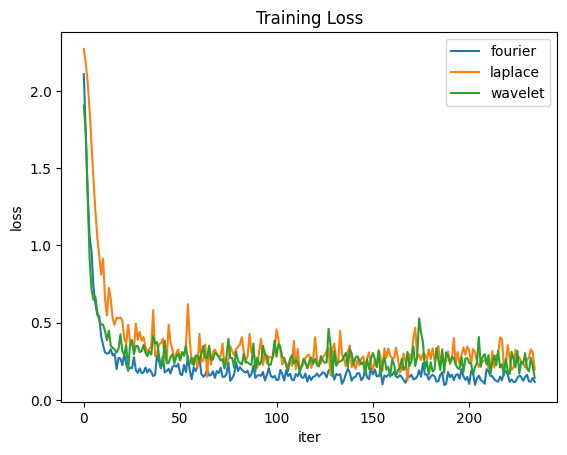

In [13]:
plt.plot(fourier_loss,label='fourier')
plt.plot(laplace_loss,label='laplace')
plt.plot(wavelet_loss,label='wavelet')
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('iter')
plt.legend()